In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [4]:
import os
import shutil

os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)
shutil.copy('kaggle.json', os.path.expanduser('~/.kaggle/'))
print("Kaggle API key has been copied.")

Kaggle API key has been copied.


In [5]:
!kaggle competitions download -c quora-question-pairs

100% 308M/309M [00:20<00:00, 18.7MB/s]
100% 309M/309M [00:20<00:00, 15.6MB/s]


In [6]:
!unzip /content/quora-question-pairs.zip -d /content/

Archive:  /content/quora-question-pairs.zip
  inflating: /content/sample_submission.csv.zip  
  inflating: /content/test.csv       
  inflating: /content/test.csv.zip   
  inflating: /content/train.csv.zip  


In [7]:
!unzip /content/quora-question-pairs.zip

Archive:  /content/quora-question-pairs.zip
replace sample_submission.csv.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [8]:
!unzip /content/train.csv.zip

Archive:  /content/train.csv.zip
  inflating: train.csv               


In [9]:
df = pd.read_csv('train.csv')
df.shape

(404290, 6)

## Data Analysis

In [10]:
df.sample(5)

,id,qid1,qid2,question1,question2,is_duplicate
142339,142339,225755,225756,Do I really need a tablet?,Do we really need tablets?,0
204895,204895,307907,307908,How can I have a happy relationship?,How can we always happy in relationships?,1
299631,299631,12346,127659,What are some good anime movies?,What are some good anime shows/films to watch?,1
144915,144915,229232,229233,What does it mean if I dream the same known pe...,Why do terrorists not attack rich Arab countries?,0
39349,39349,71343,71344,Is video game addiction even a real condition?,Is addiction to video games a real issue?,1


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [12]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [13]:
df.duplicated().sum()

0

In [14]:
df.nunique()

id              404290
qid1            290654
qid2            299364
question1       290456
question2       299174
is_duplicate         2
dtype: int64

In [15]:
print((df['is_duplicate'].value_counts()/df['is_duplicate'].count())*100)

is_duplicate
0    63.080215
1    36.919785
Name: count, dtype: float64


In [16]:
df['is_duplicate'].value_counts()

is_duplicate
0    255027
1    149263
Name: count, dtype: int64

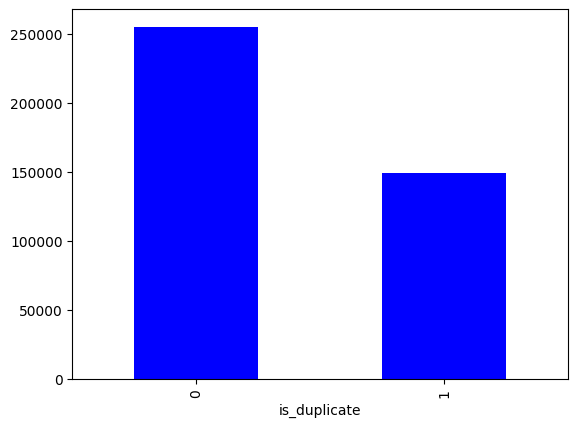

In [17]:
df['is_duplicate'].value_counts().plot(kind='bar',color='b'); # barplot of is_duplicate column

In [18]:
qid = pd.Series(df['qid1'].tolist() + df['qid2'].tolist()) #concatinating the question ids

In [19]:
# find total number of unique question ids
print('Number of unique questions',np.unique(qid).shape[0])

Number of unique questions 537933


In [20]:
qid.duplicated().sum()

270647

In [21]:
x = qid.value_counts() > 1
print('Number of questions getting repeated',x[x].shape[0]) # Using x[x] to count the number of True values

Number of questions getting repeated 111780


## Preprocessing

In [22]:
df.dropna(inplace=True)
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [23]:
df.shape

(404287, 6)

In [24]:
# We take a smaller dataset of only 50000 rows for our purpose
new_df = df.sample(n=100000, random_state=2)

In [25]:
new_df=new_df.set_index('id')

In [26]:
new_df.head()

,qid1,qid2,question1,question2,is_duplicate
id,,,,,
331535,169053,295926,How can I learn Norwegian?,What is the quickest way to learn Norwegian?,1
45407,81383,81384,How are currency rates determined?,Where and how are exchange rates determined?,1
286200,285024,406729,What is substitution?,What is a substitute for caciocavallo?,0
157195,245856,245857,How can I make iPhone 4s faster with IOS 9.2?,I have an iPhone 4S. How do I make it faster a...,1
154346,242075,242076,How can I help my girlfriend cope with her par...,What can I do to help my girlfriend through he...,1


In [27]:
# To check new sample has same proportion
print((new_df['is_duplicate'].value_counts()/new_df['is_duplicate'].count())*100)

is_duplicate
0    62.996
1    37.004
Name: count, dtype: float64


In [28]:
def replace_characters(q):

    q = str(q).lower().strip()

    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')

    q = q.replace('[math]', '')

    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)

    return q


In [29]:
def remove_contractions(q):
    contractions = {
        "ain't": "am not",
        "aren't": "are not",
        "can't": "can not",
        "can't've": "can not have",
        "'cause": "because",
        "could've": "could have",
        "couldn't": "could not",
        "couldn't've": "could not have",
        "didn't": "did not",
        "doesn't": "does not",
        "don't": "do not",
        "hadn't": "had not",
        "hadn't've": "had not have",
        "hasn't": "has not",
        "haven't": "have not",
        "he'd": "he would",
        "he'd've": "he would have",
        "he'll": "he will",
        "he'll've": "he will have",
        "he's": "he is",
        "how'd": "how did",
        "how'd'y": "how do you",
        "how'll": "how will",
        "how's": "how is",
        "i'd": "i would",
        "i'd've": "i would have",
        "i'll": "i will",
        "i'll've": "i will have",
        "i'm": "i am",
        "i've": "i have",
        "isn't": "is not",
        "it'd": "it would",
        "it'd've": "it would have",
        "it'll": "it will",
        "it'll've": "it will have",
        "it's": "it is",
        "let's": "let us",
        "ma'am": "madam",
        "mayn't": "may not",
        "might've": "might have",
        "mightn't": "might not",
        "mightn't've": "might not have",
        "must've": "must have",
        "mustn't": "must not",
        "mustn't've": "must not have",
        "needn't": "need not",
        "needn't've": "need not have",
        "o'clock": "of the clock",
        "oughtn't": "ought not",
        "oughtn't've": "ought not have",
        "shan't": "shall not",
        "sha'n't": "shall not",
        "shan't've": "shall not have",
        "she'd": "she would",
        "she'd've": "she would have",
        "she'll": "she will",
        "she'll've": "she will have",
        "she's": "she is",
        "should've": "should have",
        "shouldn't": "should not",
        "shouldn't've": "should not have",
        "so've": "so have",
        "so's": "so as",
        "that'd": "that would",
        "that'd've": "that would have",
        "that's": "that is",
        "there'd": "there would",
        "there'd've": "there would have",
        "there's": "there is",
        "they'd": "they would",
        "they'd've": "they would have",
        "they'll": "they will",
        "they'll've": "they will have",
        "they're": "they are",
        "they've": "they have",
        "to've": "to have",
        "wasn't": "was not",
        "we'd": "we would",
        "we'd've": "we would have",
        "we'll": "we will",
        "we'll've": "we will have",
        "we're": "we are",
        "we've": "we have",
        "weren't": "were not",
        "what'll": "what will",
        "what'll've": "what will have",
        "what're": "what are",
        "what's": "what is",
        "what've": "what have",
        "when's": "when is",
        "when've": "when have",
        "where'd": "where did",
        "where's": "where is",
        "where've": "where have",
        "who'll": "who will",
        "who'll've": "who will have",
        "who's": "who is",
        "who've": "who have",
        "why's": "why is",
        "why've": "why have",
        "will've": "will have",
        "won't": "will not",
        "won't've": "will not have",
        "would've": "would have",
        "wouldn't": "would not",
        "wouldn't've": "would not have",
        "y'all": "you all",
        "y'all'd": "you all would",
        "y'all'd've": "you all would have",
        "y'all're": "you all are",
        "y'all've": "you all have",
        "you'd": "you would",
        "you'd've": "you would have",
        "you'll": "you will",
        "you'll've": "you will have",
        "you're": "you are",
        "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]
        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have") # for contractions that may have missed
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")

    return q


In [30]:
import re
from bs4 import BeautifulSoup

def remove_html(q):
  q = BeautifulSoup(q)
  q = q.get_text()
  return q

def remove_punc(q):
  pattern = re.compile('\W')
  q = re.sub(pattern, ' ', q).strip()
  return q

In [31]:
def process_text(text):
    text = replace_characters(text)
    text = remove_contractions(text)
    text = remove_html(text)
    text = remove_punc(text)
    return text


In [32]:
new_df['question1'] = new_df['question1'].apply(process_text)
new_df['question2'] = new_df['question2'].apply(process_text)

In [33]:
new_df.head()

,qid1,qid2,question1,question2,is_duplicate
id,,,,,
331535,169053,295926,how can i learn norwegian,what is the quickest way to learn norwegian,1
45407,81383,81384,how are currency rates determined,where and how are exchange rates determined,1
286200,285024,406729,what is substitution,what is a substitute for caciocavallo,0
157195,245856,245857,how can i make iphone 4s faster with ios 9 2,i have an iphone 4s how do i make it faster a...,1
154346,242075,242076,how can i help my girlfriend cope with her par...,what can i do to help my girlfriend through he...,1


In [34]:
!pip install nltk
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [35]:
from nltk.corpus import stopwords

def remove_sw(text):
  new_text=[]

  for word in text.split():
    if word in stopwords.words('english'):
      new_text.append("")
    else:
      new_text.append(word)

  return " ".join(new_text)

In [36]:
df_wo_stopwords=new_df.copy()
df_wo_stopwords['question1'] = df_wo_stopwords['question1'].apply(remove_sw)
df_wo_stopwords['question2'] = df_wo_stopwords['question2'].apply(remove_sw)

In [37]:
#Lemmatization

from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

# Download NLTK resources if not already downloaded
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# Function to map NLTK POS tags to WordNet POS tags for lemmatization
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # default to noun if POS tag not found

# Function to perform lemmatization on a text
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    lemmatized_tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(tag)) for token, tag in pos_tags]
    return ' '.join(lemmatized_tokens)

# Apply lemmatization to the columns
df_wo_stopwords['question1_lemmatized'] = df_wo_stopwords['question1'].apply(lemmatize_text)
df_wo_stopwords['question2_lemmatized'] = df_wo_stopwords['question2'].apply(lemmatize_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## Feature Engineering

In [38]:
# Length of q1 and q2
df_wo_stopwords['q1_len'] = df_wo_stopwords['question1_lemmatized'].str.len()
df_wo_stopwords['q2_len'] = df_wo_stopwords['question2_lemmatized'].str.len()

In [39]:
# No. of words in q1 and q2

df_wo_stopwords['q1_num_words'] = df_wo_stopwords['question1_lemmatized'].apply(lambda row: len(row.split(" ")))
df_wo_stopwords['q2_num_words'] = df_wo_stopwords['question2_lemmatized'].apply(lambda row: len(row.split(" ")))
df_wo_stopwords.head()

,qid1,qid2,question1,question2,is_duplicate,question1_lemmatized,question2_lemmatized,q1_len,q2_len,q1_num_words,q2_num_words
id,,,,,,,,,,,
331535,169053,295926,learn norwegian,quickest way learn norwegian,1,learn norwegian,quick way learn norwegian,15,25,2,4
45407,81383,81384,currency rates determined,exchange rates determined,1,currency rate determine,exchange rate determine,23,23,3,3
286200,285024,406729,substitution,substitute caciocavallo,0,substitution,substitute caciocavallo,12,23,1,2
157195,245856,245857,make iphone 4s faster ios 9 2,iphone 4s make faster comfortable use,1,make iphone 4 faster io 9 2,iphone 4 make faster comfortable use,27,36,7,6
154346,242075,242076,help girlfriend cope parents divorce,help girlfriend parents divorce,1,help girlfriend cope parent divorce,help girlfriend parent divorce,35,30,5,4


In [40]:
# No. of Common_words in q1 and q2

def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1_lemmatized'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2_lemmatized'].split(" ")))
    return len(w1 & w2)

df_wo_stopwords['word_common'] = df_wo_stopwords.apply(common_words, axis=1)
df_wo_stopwords.head()

,qid1,qid2,question1,question2,is_duplicate,question1_lemmatized,question2_lemmatized,q1_len,q2_len,q1_num_words,q2_num_words,word_common
id,,,,,,,,,,,,
331535,169053,295926,learn norwegian,quickest way learn norwegian,1,learn norwegian,quick way learn norwegian,15,25,2,4,2
45407,81383,81384,currency rates determined,exchange rates determined,1,currency rate determine,exchange rate determine,23,23,3,3,2
286200,285024,406729,substitution,substitute caciocavallo,0,substitution,substitute caciocavallo,12,23,1,2,0
157195,245856,245857,make iphone 4s faster ios 9 2,iphone 4s make faster comfortable use,1,make iphone 4 faster io 9 2,iphone 4 make faster comfortable use,27,36,7,6,4
154346,242075,242076,help girlfriend cope parents divorce,help girlfriend parents divorce,1,help girlfriend cope parent divorce,help girlfriend parent divorce,35,30,5,4,4


In [41]:
# Total no. of words in q1 + q2

def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1_lemmatized'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2_lemmatized'].split(" ")))
    return (len(w1) + len(w2))

df_wo_stopwords['word_total'] = df_wo_stopwords.apply(total_words, axis=1)
df_wo_stopwords.head()

,qid1,qid2,question1,question2,is_duplicate,question1_lemmatized,question2_lemmatized,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total
id,,,,,,,,,,,,,
331535,169053,295926,learn norwegian,quickest way learn norwegian,1,learn norwegian,quick way learn norwegian,15,25,2,4,2,6
45407,81383,81384,currency rates determined,exchange rates determined,1,currency rate determine,exchange rate determine,23,23,3,3,2,6
286200,285024,406729,substitution,substitute caciocavallo,0,substitution,substitute caciocavallo,12,23,1,2,0,3
157195,245856,245857,make iphone 4s faster ios 9 2,iphone 4s make faster comfortable use,1,make iphone 4 faster io 9 2,iphone 4 make faster comfortable use,27,36,7,6,4,13
154346,242075,242076,help girlfriend cope parents divorce,help girlfriend parents divorce,1,help girlfriend cope parent divorce,help girlfriend parent divorce,35,30,5,4,4,9


In [42]:
# ratio of word_common to word_total
df_wo_stopwords['word_share'] = round(df_wo_stopwords['word_common']/df_wo_stopwords['word_total'],2)
df_wo_stopwords.head()

,qid1,qid2,question1,question2,is_duplicate,question1_lemmatized,question2_lemmatized,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share
id,,,,,,,,,,,,,,
331535,169053,295926,learn norwegian,quickest way learn norwegian,1,learn norwegian,quick way learn norwegian,15,25,2,4,2,6,0.33
45407,81383,81384,currency rates determined,exchange rates determined,1,currency rate determine,exchange rate determine,23,23,3,3,2,6,0.33
286200,285024,406729,substitution,substitute caciocavallo,0,substitution,substitute caciocavallo,12,23,1,2,0,3,0.00
157195,245856,245857,make iphone 4s faster ios 9 2,iphone 4s make faster comfortable use,1,make iphone 4 faster io 9 2,iphone 4 make faster comfortable use,27,36,7,6,4,13,0.31
154346,242075,242076,help girlfriend cope parents divorce,help girlfriend parents divorce,1,help girlfriend cope parent divorce,help girlfriend parent divorce,35,30,5,4,4,9,0.44


In [43]:
!pip install fuzzywuzzy

In [44]:
from fuzzywuzzy import fuzz

def fetch_fuzzy_features(row):

    q1 = row['question1_lemmatized']
    q2 = row['question2_lemmatized']

    fuzzy_features = [0.0]*4

    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [45]:
fuzzy_features = df_wo_stopwords.apply(fetch_fuzzy_features, axis=1)

# Creating new feature columns for fuzzy features
df_wo_stopwords['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
df_wo_stopwords['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
df_wo_stopwords['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
df_wo_stopwords['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

In [46]:
print(df_wo_stopwords.shape)
df_wo_stopwords.head()

(100000, 18)


,qid1,qid2,question1,question2,is_duplicate,question1_lemmatized,question2_lemmatized,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
id,,,,,,,,,,,,,,,,,,
331535,169053,295926,learn norwegian,quickest way learn norwegian,1,learn norwegian,quick way learn norwegian,15,25,2,4,2,6,0.33,75,100,75,100
45407,81383,81384,currency rates determined,exchange rates determined,1,currency rate determine,exchange rate determine,23,23,3,3,2,6,0.33,74,77,61,76
286200,285024,406729,substitution,substitute caciocavallo,0,substitution,substitute caciocavallo,12,23,1,2,0,3,0.00,63,75,51,51
157195,245856,245857,make iphone 4s faster ios 9 2,iphone 4s make faster comfortable use,1,make iphone 4 faster io 9 2,iphone 4 make faster comfortable use,27,36,7,6,4,13,0.31,57,63,67,85
154346,242075,242076,help girlfriend cope parents divorce,help girlfriend parents divorce,1,help girlfriend cope parent divorce,help girlfriend parent divorce,35,30,5,4,4,9,0.44,92,83,92,100


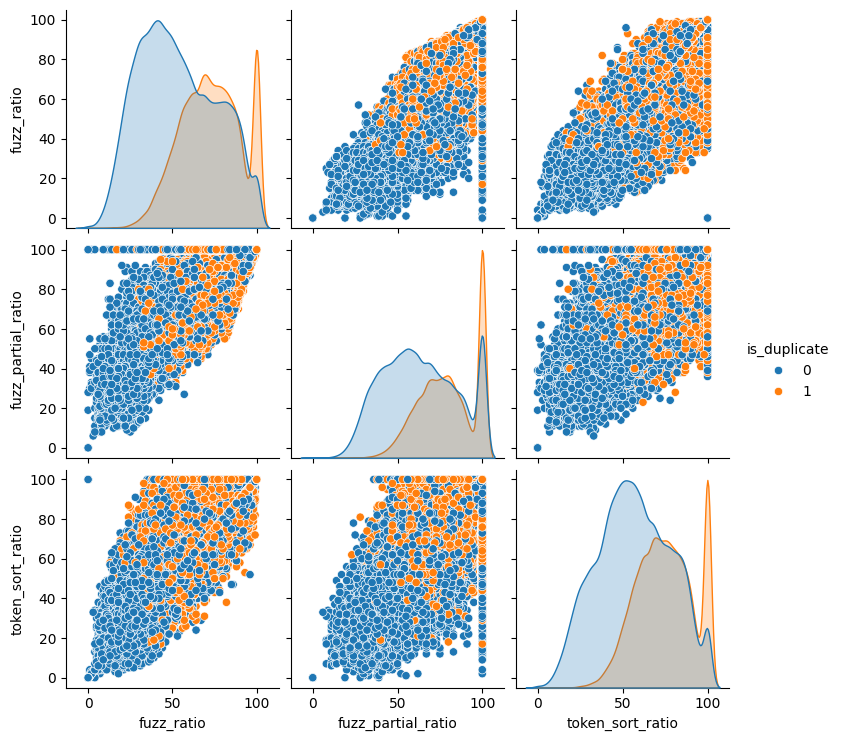

In [47]:
sns.pairplot(df_wo_stopwords[['fuzz_ratio', 'fuzz_partial_ratio', 'token_sort_ratio','is_duplicate']],hue='is_duplicate')

In [48]:
# Check first word and last word similarity
df_wo_stopwords['first_word_same'] = (df_wo_stopwords['question1_lemmatized'].str.split().str[0] == df_wo_stopwords['question2_lemmatized'].str.split().str[0]).astype(int)
df_wo_stopwords['last_word_same'] = (df_wo_stopwords['question1_lemmatized'].str.split().str[-1] == df_wo_stopwords['question2_lemmatized'].str.split().str[-1]).astype(int)
df_wo_stopwords.head()

,qid1,qid2,question1,question2,is_duplicate,question1_lemmatized,question2_lemmatized,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio,first_word_same,last_word_same
id,,,,,,,,,,,,,,,,,,,,
331535,169053,295926,learn norwegian,quickest way learn norwegian,1,learn norwegian,quick way learn norwegian,15,25,2,4,2,6,0.33,75,100,75,100,0,1
45407,81383,81384,currency rates determined,exchange rates determined,1,currency rate determine,exchange rate determine,23,23,3,3,2,6,0.33,74,77,61,76,0,1
286200,285024,406729,substitution,substitute caciocavallo,0,substitution,substitute caciocavallo,12,23,1,2,0,3,0.00,63,75,51,51,0,0
157195,245856,245857,make iphone 4s faster ios 9 2,iphone 4s make faster comfortable use,1,make iphone 4 faster io 9 2,iphone 4 make faster comfortable use,27,36,7,6,4,13,0.31,57,63,67,85,0,0
154346,242075,242076,help girlfriend cope parents divorce,help girlfriend parents divorce,1,help girlfriend cope parent divorce,help girlfriend parent divorce,35,30,5,4,4,9,0.44,92,83,92,100,1,1


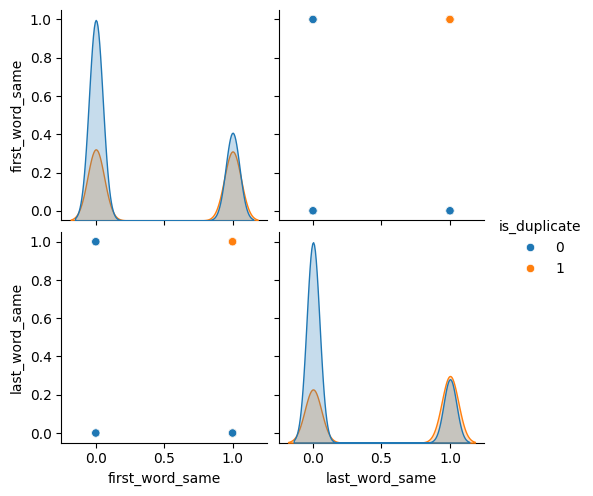

In [49]:
sns.pairplot(df_wo_stopwords[['first_word_same', 'last_word_same', 'is_duplicate']],hue='is_duplicate')

## Creating Word Embeddings

In [50]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

In [51]:
# Tokenize the text in each column
q1_token = df_wo_stopwords['question1_lemmatized'].apply(word_tokenize)
q2_token = df_wo_stopwords['question2_lemmatized'].apply(word_tokenize)

In [52]:
sentences = q1_token.tolist() + q2_token.tolist()

In [53]:
sentences[0]

['learn', 'norwegian']

In [54]:
model = Word2Vec(sentences,
                 vector_size=150, #Dimensionality of the word vectors
                 window=5, # Maximum distance between the current and predicted word within a sentence.
                 min_count=1, #Ignores all words with a total frequency lower than this.
                 sg=0) #sg=0 uses CBOW, sg=1 uses skip-gram.

In [55]:
def get_sentence_vector(sentence, model):
    words = [word for word in sentence if word in model.wv]
    if not words:
        return np.zeros(model.vector_size)
    return np.mean([model.wv[word] for word in words], axis=0)

In [56]:
q1_vector = q1_token.apply(lambda x: get_sentence_vector(x, model))
q2_vector = q2_token.apply(lambda x: get_sentence_vector(x, model))

In [57]:
df_wo_stopwords['q1_vector']=q1_vector
df_wo_stopwords['q2_vector']=q2_vector
df_wo_stopwords.head(5)

,qid1,qid2,question1,question2,is_duplicate,question1_lemmatized,question2_lemmatized,q1_len,q2_len,q1_num_words,...,word_total,word_share,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio,first_word_same,last_word_same,q1_vector,q2_vector
id,,,,,,,,,,,,,,,,,,,,,
331535,169053,295926,learn norwegian,quickest way learn norwegian,1,learn norwegian,quick way learn norwegian,15,25,2,...,6,0.33,75,100,75,100,0,1,"[0.45818353, -0.6839252, -0.22063684, -0.01989...","[0.33195198, -0.27822626, -0.17950681, 0.05732..."
45407,81383,81384,currency rates determined,exchange rates determined,1,currency rate determine,exchange rate determine,23,23,3,...,6,0.33,74,77,61,76,0,1,"[0.1739652, 0.059682768, -0.62923723, 0.799001...","[0.28601643, 0.07984697, -0.43228832, 0.481234..."
286200,285024,406729,substitution,substitute caciocavallo,0,substitution,substitute caciocavallo,12,23,1,...,3,0.00,63,75,51,51,0,0,"[0.039367203, -0.01510214, -0.03057291, -0.017...","[0.23063967, -0.042384733, -0.24409097, 0.0358..."
157195,245856,245857,make iphone 4s faster ios 9 2,iphone 4s make faster comfortable use,1,make iphone 4 faster io 9 2,iphone 4 make faster comfortable use,27,36,7,...,13,0.31,57,63,67,85,0,0,"[-0.76113933, 0.38793185, -0.09515202, -0.1137...","[-0.5124834, 0.19614075, -0.3455001, 0.2358932..."
154346,242075,242076,help girlfriend cope parents divorce,help girlfriend parents divorce,1,help girlfriend cope parent divorce,help girlfriend parent divorce,35,30,5,...,9,0.44,92,83,92,100,1,1,"[-0.24979594, 0.18825756, 0.009470472, 0.15795...","[-0.3761547, 0.23395444, 0.0037025, 0.12824982..."


In [58]:
# Determine the length of the vectors
vector1_length = len(df_wo_stopwords['q1_vector'].iloc[0])
vector2_length = len(df_wo_stopwords['q2_vector'].iloc[0])

# Create new columns for each element in the vector
for i in range(vector1_length):
    df_wo_stopwords[f'question1_vector_{i}'] = df_wo_stopwords['q1_vector'].apply(lambda x: x[i])

for i in range(vector2_length):
    df_wo_stopwords[f'question2_vector_{i}'] = df_wo_stopwords['q2_vector'].apply(lambda x: x[i])

df_wo_stopwords.head()

,qid1,qid2,question1,question2,is_duplicate,question1_lemmatized,question2_lemmatized,q1_len,q2_len,q1_num_words,...,question2_vector_140,question2_vector_141,question2_vector_142,question2_vector_143,question2_vector_144,question2_vector_145,question2_vector_146,question2_vector_147,question2_vector_148,question2_vector_149
id,,,,,,,,,,,,,,,,,,,,,
331535,169053,295926,learn norwegian,quickest way learn norwegian,1,learn norwegian,quick way learn norwegian,15,25,2,...,0.285413,0.206543,0.426675,0.693028,0.291553,0.356331,-0.140980,-0.512476,0.642846,-0.327432
45407,81383,81384,currency rates determined,exchange rates determined,1,currency rate determine,exchange rate determine,23,23,3,...,0.062151,0.812498,-0.094504,0.615381,0.553530,0.467826,0.422171,-0.369257,0.326722,-0.120055
286200,285024,406729,substitution,substitute caciocavallo,0,substitution,substitute caciocavallo,12,23,1,...,0.048807,0.053058,0.117621,0.089212,0.123199,-0.011078,0.120039,-0.134951,0.120421,-0.172538
157195,245856,245857,make iphone 4s faster ios 9 2,iphone 4s make faster comfortable use,1,make iphone 4 faster io 9 2,iphone 4 make faster comfortable use,27,36,7,...,0.410118,0.143812,0.170772,1.084446,0.247120,1.067765,0.139202,-0.404906,0.248367,-0.684850
154346,242075,242076,help girlfriend cope parents divorce,help girlfriend parents divorce,1,help girlfriend cope parent divorce,help girlfriend parent divorce,35,30,5,...,0.061375,0.382031,0.172455,-0.193236,0.520276,0.400872,-0.604805,-0.414804,0.603547,-0.782559


In [59]:
df_wo_stopwords.shape

(100000, 322)

In [60]:
q1_vector.iloc[0]

array([ 0.45818353, -0.6839252 , -0.22063684, -0.01989363, -0.19226131,
        0.01918062,  0.4311793 ,  1.0412872 , -0.8027147 , -0.0762935 ,
       -0.2729042 , -0.13094753, -1.0754174 ,  1.1869994 , -0.6594956 ,
       -0.10470451,  0.4544167 ,  0.34373456,  0.32060328,  0.17502253,
       -0.03581908, -0.866116  ,  0.2140661 , -0.00611613,  0.06994928,
       -0.1813811 ,  0.01165789,  0.09323667, -0.5067479 , -0.5127792 ,
        0.8380888 , -0.37451205, -0.1037143 , -0.3240875 ,  0.39408258,
       -0.4926692 ,  0.5881117 ,  0.8990455 ,  0.30123734, -0.59899884,
       -0.5205943 , -0.54746324, -0.14660679,  0.14971305, -0.37986052,
        0.38663733,  0.14855528, -0.9759396 ,  0.74896646,  0.31460202,
       -0.68395084, -0.27902102,  0.15210769,  0.1339689 ,  0.48256752,
        0.8725468 , -0.07821581, -0.3718    , -0.02096806,  0.42635533,
        0.74860185,  0.0080061 , -0.02364116,  0.1712091 ,  0.48702845,
        0.27523395, -0.17545924,  0.08435141, -0.62380713, -0.60

In [61]:
def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

cosine_similarity(q1_vector.iloc[0],q2_vector.iloc[0])

0.84134513

In [62]:
df_wo_stopwords['similarity'] = df_wo_stopwords.apply(lambda row: cosine_similarity(row['q1_vector'], row['q2_vector']), axis=1)
df_wo_stopwords['similarity']

id
331535    0.841345
45407     0.957547
286200    0.802337
157195    0.922167
154346    0.995367
            ...   
280170    0.619563
251765    0.888960
150382    0.594482
305012    0.905984
166469    1.000000
Name: similarity, Length: 100000, dtype: float64

In [63]:
df_wo_stopwords.columns

Index(['qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'question1_lemmatized', 'question2_lemmatized', 'q1_len', 'q2_len',
       'q1_num_words',
       ...
       'question2_vector_141', 'question2_vector_142', 'question2_vector_143',
       'question2_vector_144', 'question2_vector_145', 'question2_vector_146',
       'question2_vector_147', 'question2_vector_148', 'question2_vector_149',
       'similarity'],
      dtype='object', length=323)

In [64]:
final_df=df_wo_stopwords.drop(['qid1', 'qid2', 'question1', 'question2',
       'question1_lemmatized', 'question2_lemmatized','q1_vector','q2_vector'],axis=1)

In [65]:
final_df.shape

(100000, 315)

## Evaluating the model

In [66]:
final_df.head(5)

,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share,fuzz_ratio,fuzz_partial_ratio,...,question2_vector_141,question2_vector_142,question2_vector_143,question2_vector_144,question2_vector_145,question2_vector_146,question2_vector_147,question2_vector_148,question2_vector_149,similarity
id,,,,,,,,,,,,,,,,,,,,,
331535,1,15,25,2,4,2,6,0.33,75,100,...,0.206543,0.426675,0.693028,0.291553,0.356331,-0.140980,-0.512476,0.642846,-0.327432,0.841345
45407,1,23,23,3,3,2,6,0.33,74,77,...,0.812498,-0.094504,0.615381,0.553530,0.467826,0.422171,-0.369257,0.326722,-0.120055,0.957547
286200,0,12,23,1,2,0,3,0.00,63,75,...,0.053058,0.117621,0.089212,0.123199,-0.011078,0.120039,-0.134951,0.120421,-0.172538,0.802337
157195,1,27,36,7,6,4,13,0.31,57,63,...,0.143812,0.170772,1.084446,0.247120,1.067765,0.139202,-0.404906,0.248367,-0.684850,0.922167
154346,1,35,30,5,4,4,9,0.44,92,83,...,0.382031,0.172455,-0.193236,0.520276,0.400872,-0.604805,-0.414804,0.603547,-0.782559,0.995367


In [67]:
df_final=final_df.dropna()

In [68]:
X=df_final.drop(['is_duplicate'],axis=1)
y=df_final['is_duplicate']

In [69]:
X.shape,y.shape

((99967, 314), (99967,))

In [70]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [71]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Building an ANN model

In [82]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization

model=Sequential()
model.add(Dense(units=256,kernel_initializer = 'uniform',input_dim=314,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=128,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(units=128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(units=32,activation='relu'))
model.add(Dense(units=1,activation='sigmoid'))

In [83]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [84]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 256)               80640     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_7 (Dense)             (None, 128)               16512     
                                                                 
 batch_normalization_2 (Bat  (None, 128)               512       
 chNormalization)                                     

In [86]:
history = model.fit(X_train_scaled,y_train,batch_size=32,epochs=100,verbose=1,validation_split=0.2)

Epoch 1/100
2000/2000 [==============================] - 14s 7ms/step - loss: 0.4275 - accuracy: 0.7863 - val_loss: 0.4320 - val_accuracy: 0.7813
Epoch 2/100
2000/2000 [==============================] - 14s 7ms/step - loss: 0.4231 - accuracy: 0.7904 - val_loss: 0.4280 - val_accuracy: 0.7851
Epoch 3/100
2000/2000 [==============================] - 14s 7ms/step - loss: 0.4185 - accuracy: 0.7918 - val_loss: 0.4251 - val_accuracy: 0.7871
Epoch 4/100
2000/2000 [==============================] - 14s 7ms/step - loss: 0.4150 - accuracy: 0.7944 - val_loss: 0.4298 - val_accuracy: 0.7872
Epoch 5/100
2000/2000 [==============================] - 14s 7ms/step - loss: 0.4129 - accuracy: 0.7947 - val_loss: 0.4260 - val_accuracy: 0.7847
Epoch 6/100
2000/2000 [==============================] - 13s 6ms/step - loss: 0.4076 - accuracy: 0.7999 - val_loss: 0.4238 - val_accuracy: 0.7891
Epoch 7/100
2000/2000 [==============================] - 13s 7ms/step - loss: 0.4083 - accuracy: 0.7970 - val_loss: 0.4202 -

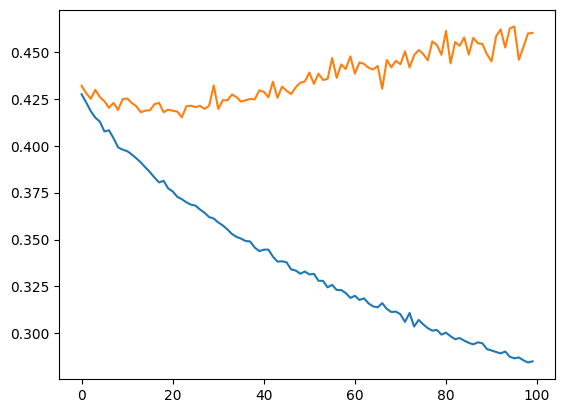

In [87]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

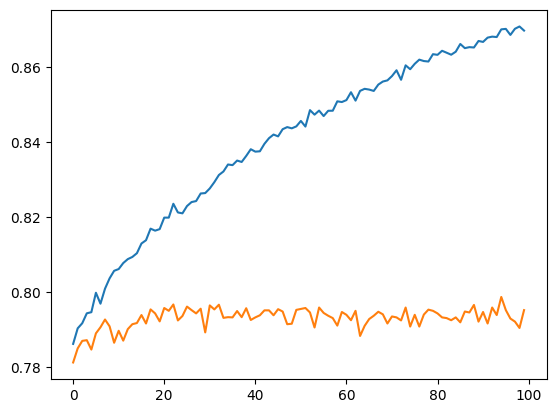

In [91]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [88]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

precision = precision_score(y_test, y_pred)
print("Precision:", precision)

recall = recall_score(y_test, y_pred)
print("Recall:", recall)

f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

Precision: 0.759090909090909
Recall: 0.6798751526665762
F1 Score: 0.7173025986112106


In [89]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)

array([[11035,  1590],
       [ 2359,  5010]])

625/625 [==============================] - 1s 2ms/step


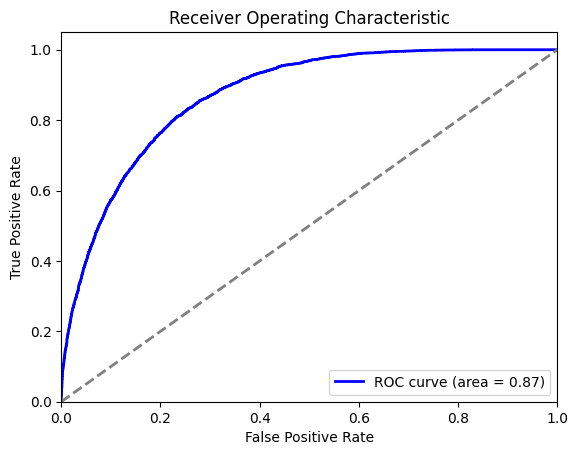

In [97]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc # Import auc

# Use predict to get probabilities, then extract for class 1
y_prob = model.predict(X_test_scaled)[:, 0]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)  # Use auc function here

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [98]:
from joblib import Parallel, delayed
import joblib

# Save the model as a pickle in a file
joblib.dump(model, '/content/nlp_model.pkl')

['/content/nlp_model.pkl']